In [1]:
def writeHadoopResults(error, iterations, outputFile, inputName):
    with open(outputFile, 'a+') as f:
        f.write(inputName + ",hadoop,-,-," + iterations + "," + error + ",\n")

In [2]:
def calcElaspedTime(minA, secA, minB, secB):
    if minA == minB:
        return secB - secA
    
    AtoMinute = 60 - secA
    MinDiff = minB - minA - 1
    return AtoMinute + MinDiff*60 + secB

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from IPython.display import display
from mpl_toolkits.mplot3d import Axes3D
from collections import defaultdict
%matplotlib notebook 

In [8]:
def hadoopIterations(filename):
    #TAKES OUTPUT FILE AND GRABS ITER COUNT
    with open(filename) as f:
        finalLine = ""
        for line in f:
            if "final" in line:
                finalLine = line
    value = finalLine.split("-")[-2]
    return int(value) + 1

In [4]:
def numberPoints(goal, dim):
    GB = 1024**3
    WRITE_PT = 18
    PERCENTAGE = .15
    
    ptsNeed = goal*GB / WRITE_PT
    pairsNeed = ptsNeed / dim
    
    small = math.ceil( pairsNeed * PERCENTAGE)
    big = math.floor( pairsNeed * (1 - PERCENTAGE))
    return small, big
    

In [5]:
numberPoints(1.5, 5000)

(2685, 15211)

In [3]:
import math
math.ceil(1.4)

2

In [4]:
GB = 1024**3
WRITE_PT = 18
GOAL_GB = 1.5
DIM = 5000

ptsNeeded = GOAL_GB * GB / WRITE_PT
pairsNeed = ptsNeeded / DIM
print(pairsNeed*(1-.15))

15211.342506666664


In [2]:
print(pairsNeed)

17895.697066666664


In [9]:
hadoopIterations("./hadoop/iter_count.txt")

3

In [3]:
r = np.random.normal(5, 1, 5000).tolist()
s = ' '.join(map(str, r))  + "\n"
print(s)

5.803017200445501 4.445329930205215 4.312950215222638 5.426556855136116 5.206101948843269 6.025404892066547 5.8200113020953035 5.063857295833551 4.941535114334844 5.513873437961606 4.059485064005107 4.704016488493862 4.868420794339354 3.796516049025718 3.3821657267017646 2.909539752579113 5.6725233012414105 3.844438400312089 5.605925374460596 3.5334223753579534 5.313760076978335 5.376837339657448 4.549555495599746 5.7674799829927075 6.507182161808455 4.512996298143923 5.719646001505976 4.032846296193203 3.219227475532268 4.942433954406886 3.134411864176743 3.8360094687776645 5.102061081799446 4.523714058895193 5.747003769811624 4.166898526510941 5.397333219778296 5.5920766898741965 5.4299867853484995 4.786288213285937 3.22898627936016 6.012019524523051 4.718354189935708 5.5838667673779945 4.587272493889014 5.400374427583728 2.9375266581847925 4.237507152346476 3.5819733631441117 4.209735053789288 5.2243589468729645 5.910569902863535 4.196930789891601 4.640386180982822 5.073121046896937

In [8]:
with open("ugh.txt", "w") as f:
    for _ in range(10000):
        l = np.random.normal(3, 1, 5000).tolist()
        f.write( ' '.join(map(str, l)) + "\n")

with open("ugh.txt", 'a+') as f:
    for _ in range(1302):
        r = np.random.normal(5, 1, 5000).tolist()
        f.write( ' '.join(map(str, r))  + "\n")

OSError: [Errno 5] Input/output error

In [42]:
def hadoopGatherCanopies(filename):
    #GATHER CLUSTER DATA POINTS
    with open(filename) as f:
        clusters = {}
        for line in f:
            if line[0] is '{':
                center = line.split('"c":[')[1]
                center = center.split("]")[0]
                clusters[center] = []
            elif 'distance' in line:
                values = line.strip().split(': [')[-1][:-1]
                clusters[center].append(values)
    return clusters

In [62]:
def hadoopError(filename):
    with open(filename) as f:
        error = 0
        for line in f:
            if 'distance' in line:
                value = line.split("distance=")[1]
                value = value.split(']:')[0]
                error += float(value)
    return error

In [119]:
def plotClusters(canopies, name):
    #PLOTS HADOOP/SPARK CLUSTERS --ONLY USE IF R^3
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')

    for k, v in canopies.items():
        x,y,z = [], [], []
        for pt in v:
            X,Y,Z = list(map( float, pt.split(',') ) )
            x.append(X)
            y.append(Y)
            z.append(Z)
        ax.scatter(x, y, z)

    plt.title(name + " Clusters")
    plt.savefig(name + ".png")

In [120]:
hadoopCanopies = hadoopGatherCanopies("./hadoop/results.txt")

In [121]:
hadoopError("./hadoop/results.txt")

493.1828392436146

<IPython.core.display.Javascript object>


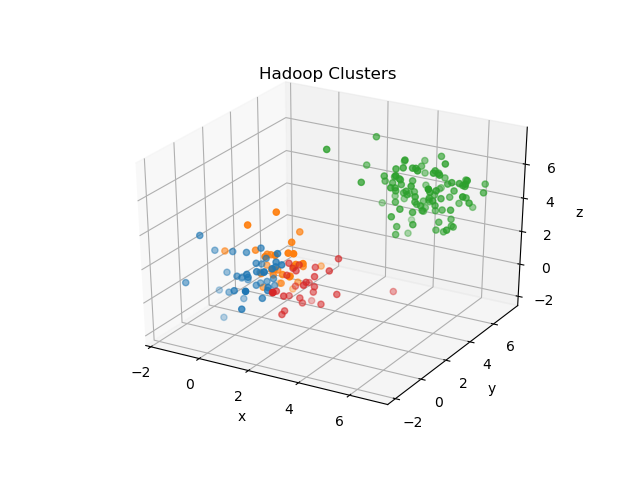

In [122]:
plotClusters(hadoopCanopies, "Hadoop")

In [87]:
def sparkGatherCanopies(centerFile, pointsFile):
    with open(centerFile) as f:
        centers = {}
        for line in f:
            values = line.strip().split('],')
            index = int( values[1][:-1] )
            coord = values[0][2:]
            centers[index] = coord
    with open(pointsFile) as f:
        points = defaultdict(list)
        for line in f:
            values = line.strip().split(",[")
            index = int(values[0][1:])
            coord = values[1][:-2]
            points[index].append(coord)
    canopies = {}
    for k, v in centers.items():
        canopies[v] = points[k]
    return canopies

In [125]:
sparkCanopy = sparkGatherCanopies("./spark/centers.txt", "./spark/points.txt")

<IPython.core.display.Javascript object>


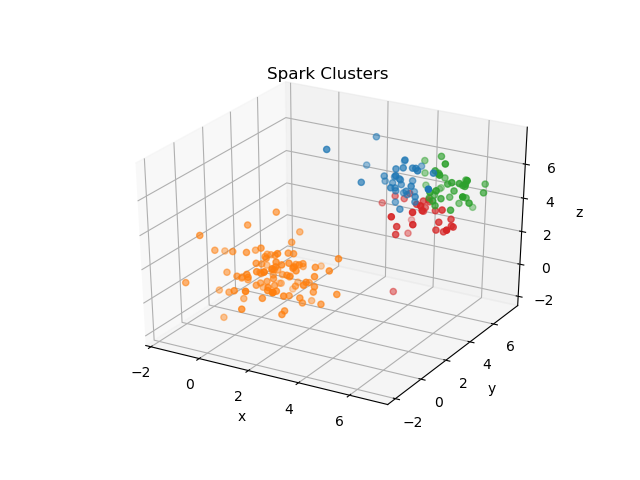

In [126]:
plotClusters(sparkCanopy, "Spark")

In [132]:
def sparkResults(filename, output):
    with open(filename) as f:
        current = f.readlines()[-4:]
        buildTime = current[0].strip().split(" ")[-2] 
        iterTime = current[1].strip().split(" ")[-2] 
        iterations = current[2].strip().split(" ")[-2] 
        cost = current[3].strip()[:-1].split(" ")[-1]
    with open(output, 'a+') as f:
        f.write("spark," + buildTime + "," + iterTime + "," + iterations + "," + cost + ",\n")

In [130]:
sparkResults("./spark/SparkDriver.log", "results.csv")